# Descriptive analysis of stroke pathway data

Terminology:
* **Modified Ranking Scale (mRS)** - measures disability/dependence after stroke (0 is no symptoms, 6 is death)
    - data['prior_disability'] is mRS before stroke
    - data['discharge_disability'] is mRS at discharge
    - data['disability_6_month'] is mRS at 6 months
* **National Institutes of Health Stroke Scale (NIHSS)** - measures stroke severity (0 is normal functioning, 4 is completely impaired)
    - data['stroke_severity'] is NIHSS on arrival
* **Intravenous thrombolysis (IVT)** - sometimes used in project as abbreviation for thrombolysis, most common type, other type is **intraarterial thrombolysis (IAT)**
* **Mechanical thrombectomy (MT)** - abbreviation often used, also referred to as **endovascular thrombectomy (EVT)**

## Set up

In [1]:
# Import packages and functions
import collections
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'

    raw_path = './../data/'
    hospitals_filename = 'stroke_hospitals_2022.csv'

    notebook = '01'


paths = Paths()

In [3]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path,
                                paths.data_filename))
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))
hospitals = pd.read_csv(os.path.join(paths.raw_path,
                                     paths.hospitals_filename))

## Overview of dataset

In [4]:
# Show shape of the data
print(f'Data shape (arrive <4hr known onset): {data.shape}')
print(f'Data shape (full dataset): {data_full.shape}')

Data shape (arrive <4hr known onset): (137019, 70)
Data shape (full dataset): (358884, 70)


In [5]:
# List all columns and show their data types and proportion of completed data
pd.DataFrame({
    'Data type': data.dtypes,
    'Proportion complete (full)': data_full.count() / data_full.shape[0],
    'Proportion complete (<4hr known)': data.count() / data.shape[0]})

,Data type,Proportion complete (full),Proportion complete (<4hr known)
id,int64,1.000000,1.000000
stroke_team,object,1.000000,1.000000
age,float64,1.000000,1.000000
male,int64,1.000000,1.000000
infarction,float64,1.000000,1.000000
onset_to_arrival_time,float64,0.670139,1.000000
onset_known,int64,1.000000,1.000000
precise_onset_known,int64,1.000000,1.000000
onset_during_sleep,int64,1.000000,1.000000
arrive_by_ambulance,float64,0.999975,0.999949


In [6]:
# Printing change in number of records due to restricting years
print(f'''
Number of records per year (full dataset):
{data_full.year.value_counts().sort_index().to_string()}
Number of records per year (arrive <4hr known onset):
{data.year.value_counts().sort_index().to_string()}''')


Number of records per year (full dataset):
2016    56210
2017    58726
2018    58281
2019    60177
2020    59082
2021    66408
Number of records per year (arrive <4hr known onset):
2016    22419
2017    23017
2018    22737
2019    23000
2020    22083
2021    23763


## Summary tables

These summarise across the whole time period (2016-2021), including years in which stroke teams had a sufficient number of admissions.

In [7]:
def analyse_by_team(dataframe):
    '''
    Analyse data by stroke team
    '''
    # Create empty dictionary with default entry as list
    # (defaultdict means if no key, it will add one)
    res = collections.defaultdict(list)

    # Loop through stroke teams
    groups = dataframe.groupby('stroke_team')
    for team, group_df in groups:

        # Analysis on full dataset
        res['stroke_team'].append(team)
        res['n_arrivals_all'].append(len(group_df.index))
        res['prop_thrombolysis_all'].append(
            (group_df['thrombolysis'].dropna() == 1).mean())
        res['mean_rankin_before_stroke_all'].append(
            group_df['prior_disability'].dropna().mean())
        res['mean_nihss_on_arrival_all'].append(
            group_df['stroke_severity'].dropna().mean())
        res['prop_onset_known_all'].append(
            (group_df['onset_known'].dropna() == 1).mean())

        # Analysis on dataset with only onset known
        df_known = group_df[group_df['onset_known'] == 1]
        res['prop_known_onset_to_arrival_4h_or_less_all'].append(
            (df_known['onset_to_arrival_time'].dropna() <= 4*60).mean())

        # Analysis on dataset with known onset to arrival <= 4 hours
        df_known_4hr = df_known[df_known['onset_to_arrival_time'] <= 4*60]
        res['mean_rankin_before_stroke_4h_known'].append(
            df_known_4hr['prior_disability'].dropna().mean())
        res['mean_nihss_on_arrival_4h_known'].append(
            df_known_4hr['stroke_severity'].dropna().mean())
        res['prop_80_plus_4h_known'].append(
            (df_known_4hr['age'].dropna() >= 80).mean())
        res['mean_onset_to_arrival_4h_known'].append(
            df_known_4hr['onset_to_arrival_time'].dropna().mean())
        res['std_onset_to_arrival_4h_known'].append(
            df_known_4hr['onset_to_arrival_time'].dropna().std())
        scan_mask = df_known_4hr['arrival_to_scan_time'].dropna() <= 4*60
        res['prop_arrival_to_scan_4h_or_less_4h_known'].append(
            scan_mask.mean())

        # Analysis on dataset with scan within 4 hours arrival and known
        # onset to arrival <=4 hours
        df_known_4hr_scan = df_known_4hr[scan_mask]
        res['mean_arrival_to_scan_4h_known_4h_scan'].append(
            df_known_4hr_scan['arrival_to_scan_time'].dropna().mean())
        res['std_arrival_to_scan_4h_known_4h_scan'].append(
            df_known_4hr_scan['arrival_to_scan_time'].dropna().std())
        thrombolysed_mask = df_known_4hr_scan['thrombolysis'].dropna() == 1
        res['prop_thrombolysis_4h_known_4h_scan'].append(
            thrombolysed_mask.mean())

        # Analysis on dataset with thrombolysis, scan within 4 hours arrival,
        # and known onset to arrival <= 4 hours
        df_thrombolysed = df_known_4hr_scan[thrombolysed_mask]

        # Mean and std scan to thrombolysis
        res['mean_scan_to_thrombolysis_4h_known_4h_scan_t'].append(
            df_thrombolysed['scan_to_thrombolysis_time'].dropna().mean())
        res['std_scan_to_thrombolysis_4h_known_4h_scan_t'].append(
            df_thrombolysed['scan_to_thrombolysis_time'].dropna().std())

        # Mean and std arrival to thrombolysis
        arrival_to_thrombolysis = (
            df_thrombolysed['arrival_to_scan_time'] +
            df_thrombolysed['scan_to_thrombolysis_time'])
        res['mean_arrival_to_thrombolysis_4h_known_4h_scan_t'].append(
            arrival_to_thrombolysis.dropna().mean())
        res['std_arrival_to_thrombolysis_4h_known_4h_scan_t'].append(
            arrival_to_thrombolysis.dropna().std())

        # Mean and std onset to thrombolysis
        onset_to_thrombolysis = (df_thrombolysed['onset_to_arrival_time'] +
                                 arrival_to_thrombolysis)
        res['mean_onset_to_thrombolysis_4h_known_4h_scan_t'].append(
            onset_to_thrombolysis.dropna().mean())
        res['std_onset_to_thrombolysis_4h_known_4h_scan_t'].append(
            onset_to_thrombolysis.dropna().std())

        # Proportion of thrombolysis that were after 180 min or 270 min
        (res['prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t']
         .append((onset_to_thrombolysis.dropna() > 180).mean()))
        (res['prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t']
         .append((onset_to_thrombolysis.dropna() > 270).mean()))

    return pd.DataFrame(res)

Results by team and overall

In [8]:
# Results by team
res_team = analyse_by_team(data_full)
display(res_team.head())

# Find averages from the team results
display(res_team.describe().T)

# Summarise entire dataset (analyse all patients together)
data_full_all = data_full.copy()
data_full_all['stroke_team'] = 'All'
res_all = analyse_by_team(data_full_all)
display(res_all.T)

,stroke_team,n_arrivals_all,prop_thrombolysis_all,mean_rankin_before_stroke_all,mean_nihss_on_arrival_all,prop_onset_known_all,prop_known_onset_to_arrival_4h_or_less_all,mean_rankin_before_stroke_4h_known,mean_nihss_on_arrival_4h_known,prop_80_plus_4h_known,...,std_arrival_to_scan_4h_known_4h_scan,prop_thrombolysis_4h_known_4h_scan,mean_scan_to_thrombolysis_4h_known_4h_scan_t,std_scan_to_thrombolysis_4h_known_4h_scan_t,mean_arrival_to_thrombolysis_4h_known_4h_scan_t,std_arrival_to_thrombolysis_4h_known_4h_scan_t,mean_onset_to_thrombolysis_4h_known_4h_scan_t,std_onset_to_thrombolysis_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t
0,Addenbrooke's Hospital,3591,0.150097,0.791423,6.537176,0.592036,0.679210,0.799169,8.472299,0.443906,...,42.681575,0.376000,25.402321,25.067363,59.413926,31.430415,161.125725,54.300428,0.334623,0.029014
1,Basildon University Hospital,2917,0.132328,0.740487,5.642784,0.648269,0.572713,0.739612,6.972299,0.383195,...,46.134821,0.356455,37.410811,23.441304,53.462162,31.568138,152.418919,52.978138,0.272973,0.027027
2,Blackpool Victoria Hospital,2901,0.092382,0.991727,7.980696,0.450190,0.692956,1.051934,10.074033,0.408840,...,41.144215,0.283705,41.264463,30.025098,72.933884,38.878838,157.933884,54.241390,0.297521,0.024793
3,Bradford and Airedale SU,3535,0.075530,1.030269,7.464498,0.442150,0.641075,0.949102,9.555888,0.344311,...,49.048408,0.265823,54.218254,29.419686,87.619048,39.034739,184.206349,51.560017,0.476190,0.047619
4,Bronglais Hospital,585,0.232479,0.769231,7.355556,0.876923,0.497076,0.800000,8.788235,0.435294,...,37.915858,0.531746,42.738806,24.904307,53.283582,27.387120,176.313433,56.819781,0.440299,0.037313


,count,mean,std,min,25%,50%,75%,max
n_arrivals_all,119.0,3015.831933,1234.298520,493.000000,2214.000000,2901.000000,3698.500000,7102.000000
prop_thrombolysis_all,119.0,0.115455,0.033976,0.020290,0.092255,0.112471,0.132787,0.249667
mean_rankin_before_stroke_all,119.0,1.019735,0.246691,0.292089,0.868008,1.014577,1.205907,1.582249
mean_nihss_on_arrival_all,119.0,7.068939,0.969051,4.528681,6.353663,7.256352,7.859639,9.300537
prop_onset_known_all,119.0,0.676087,0.130226,0.413687,0.583768,0.675706,0.753146,0.991561
prop_known_onset_to_arrival_4h_or_less_all,119.0,0.578963,0.090581,0.311774,0.525064,0.591662,0.643129,0.783972
mean_rankin_before_stroke_4h_known,119.0,1.036844,0.244880,0.371429,0.868353,1.021297,1.207830,1.592755
mean_nihss_on_arrival_4h_known,119.0,8.945415,1.046782,6.380626,8.232910,9.066451,9.596998,11.196221
prop_80_plus_4h_known,119.0,0.407762,0.059048,0.234705,0.368235,0.410435,0.448383,0.562155
mean_onset_to_arrival_4h_known,119.0,114.203466,6.811043,98.469146,110.458714,114.085392,118.737195,135.595745


,0
stroke_team,All
n_arrivals_all,358884
prop_thrombolysis_all,0.114636
mean_rankin_before_stroke_all,1.032919
mean_nihss_on_arrival_all,7.061209
prop_onset_known_all,0.670139
prop_known_onset_to_arrival_4h_or_less_all,0.569721
mean_rankin_before_stroke_4h_known,1.045928
mean_nihss_on_arrival_4h_known,8.919821
prop_80_plus_4h_known,0.406469


Comparing ages under 80 v.s. 80+

In [9]:
# By team then average
res_under_80 = analyse_by_team(data_full[data_full['age'] < 80])
res_80_plus = analyse_by_team(data_full[data_full['age'] >= 80])
display(res_under_80.head())
display(res_80_plus.head())
display(res_under_80.describe().T)
display(res_80_plus.describe().T)

# All patients together
res_all_under_80 = analyse_by_team(
    data_full_all[data_full_all['age'] < 80])
res_all_80_plus = analyse_by_team(
    data_full_all[data_full_all['age'] >= 80])
display(res_all_under_80)
display(res_all_80_plus)

,stroke_team,n_arrivals_all,prop_thrombolysis_all,mean_rankin_before_stroke_all,mean_nihss_on_arrival_all,prop_onset_known_all,prop_known_onset_to_arrival_4h_or_less_all,mean_rankin_before_stroke_4h_known,mean_nihss_on_arrival_4h_known,prop_80_plus_4h_known,...,std_arrival_to_scan_4h_known_4h_scan,prop_thrombolysis_4h_known_4h_scan,mean_scan_to_thrombolysis_4h_known_4h_scan_t,std_scan_to_thrombolysis_4h_known_4h_scan_t,mean_arrival_to_thrombolysis_4h_known_4h_scan_t,std_arrival_to_thrombolysis_4h_known_4h_scan_t,mean_onset_to_thrombolysis_4h_known_4h_scan_t,std_onset_to_thrombolysis_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t
0,Addenbrooke's Hospital,2022,0.162710,0.508408,5.431751,0.604352,0.657119,0.464508,7.179328,0.0,...,43.066987,0.406780,24.307692,21.261839,59.224359,29.417293,161.769231,54.432866,0.346154,0.022436
1,Basildon University Hospital,1780,0.144944,0.394382,4.738764,0.682022,0.550247,0.380240,6.131737,0.0,...,44.838046,0.383540,38.311741,24.030214,55.502024,33.893170,154.360324,53.757546,0.287449,0.028340
2,Blackpool Victoria Hospital,1776,0.106982,0.645833,6.806869,0.449324,0.670426,0.635514,8.865421,0.0,...,41.462814,0.331384,42.252941,28.779114,76.035294,39.910832,160.288235,54.749612,0.317647,0.017647
3,Bradford and Airedale SU,2250,0.088889,0.742667,6.598667,0.460444,0.634170,0.666667,8.856925,0.0,...,47.957487,0.306709,54.604167,29.594813,88.812500,39.775499,183.708333,50.568272,0.468750,0.041667
4,Bronglais Hospital,336,0.238095,0.369048,6.139881,0.892857,0.480000,0.326389,7.833333,0.0,...,34.777251,0.556338,43.126582,27.434475,53.835443,29.770675,175.721519,59.275960,0.417722,0.037975


,stroke_team,n_arrivals_all,prop_thrombolysis_all,mean_rankin_before_stroke_all,mean_nihss_on_arrival_all,prop_onset_known_all,prop_known_onset_to_arrival_4h_or_less_all,mean_rankin_before_stroke_4h_known,mean_nihss_on_arrival_4h_known,prop_80_plus_4h_known,...,std_arrival_to_scan_4h_known_4h_scan,prop_thrombolysis_4h_known_4h_scan,mean_scan_to_thrombolysis_4h_known_4h_scan_t,std_scan_to_thrombolysis_4h_known_4h_scan_t,mean_arrival_to_thrombolysis_4h_known_4h_scan_t,std_arrival_to_thrombolysis_4h_known_4h_scan_t,mean_onset_to_thrombolysis_4h_known_4h_scan_t,std_onset_to_thrombolysis_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t
0,Addenbrooke's Hospital,1569,0.133843,1.156150,7.961759,0.576163,0.709071,1.218409,10.092044,1.0,...,42.224864,0.337171,27.068293,29.926793,59.702439,34.341198,160.146341,54.216596,0.317073,0.039024
1,Basildon University Hospital,1137,0.112577,1.282322,7.058047,0.595427,0.612999,1.318072,8.325301,1.0,...,48.236964,0.312183,35.601626,22.196492,49.365854,25.932216,148.520325,51.371094,0.243902,0.024390
2,Blackpool Victoria Hospital,1125,0.069333,1.537778,9.833778,0.451556,0.728346,1.654054,11.821622,1.0,...,40.714297,0.211765,38.930556,32.874634,65.611111,35.523274,152.375000,52.982175,0.250000,0.041667
3,Bradford and Airedale SU,1285,0.052140,1.533852,8.980545,0.410117,0.654649,1.486957,10.886957,1.0,...,50.892954,0.186335,52.983333,29.063631,83.800000,36.620731,185.800000,55.027204,0.500000,0.066667
4,Bronglais Hospital,249,0.224900,1.309237,8.995984,0.855422,0.521127,1.414414,10.027027,1.0,...,41.653110,0.500000,42.181818,20.973609,52.490909,23.792212,177.163636,53.620326,0.472727,0.036364


,count,mean,std,min,25%,50%,75%,max
n_arrivals_all,119.0,1819.697479,799.593239,336.000000,1275.500000,1775.000000,2268.000000,5004.000000
prop_thrombolysis_all,119.0,0.126791,0.034874,0.012987,0.104105,0.123902,0.148361,0.259569
mean_rankin_before_stroke_all,119.0,0.635975,0.188122,0.184783,0.508993,0.620424,0.774716,1.142073
mean_nihss_on_arrival_all,119.0,5.921475,0.891888,3.854593,5.247939,5.964168,6.644370,8.159403
prop_onset_known_all,119.0,0.685974,0.126923,0.437428,0.596979,0.684371,0.757962,0.991202
prop_known_onset_to_arrival_4h_or_less_all,119.0,0.563262,0.091871,0.237143,0.507601,0.577328,0.628104,0.770171
mean_rankin_before_stroke_4h_known,119.0,0.604105,0.190896,0.173913,0.469974,0.590000,0.737910,1.119186
mean_nihss_on_arrival_4h_known,119.0,7.813652,1.050508,5.399031,7.164010,7.833333,8.611201,10.391534
prop_80_plus_4h_known,119.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean_onset_to_arrival_4h_known,119.0,111.857637,7.426859,96.391167,106.942200,111.283505,115.842028,144.120482


,count,mean,std,min,25%,50%,75%,max
n_arrivals_all,119.0,1196.134454,489.380202,125.000000,857.500000,1171.000000,1483.000000,2550.000000
prop_thrombolysis_all,119.0,0.098471,0.035241,0.028226,0.072092,0.095391,0.117430,0.234501
mean_rankin_before_stroke_all,119.0,1.595962,0.318412,0.608000,1.435581,1.599273,1.811544,2.237792
mean_nihss_on_arrival_all,119.0,8.807297,1.106057,5.935936,8.008114,9.054757,9.572223,11.869624
prop_onset_known_all,119.0,0.662675,0.136160,0.386152,0.558433,0.663731,0.738517,0.992048
prop_known_onset_to_arrival_4h_or_less_all,119.0,0.604613,0.091897,0.364583,0.550191,0.615187,0.664586,0.805627
mean_rankin_before_stroke_4h_known,119.0,1.665625,0.318001,0.729730,1.464976,1.677892,1.895000,2.343849
mean_nihss_on_arrival_4h_known,119.0,10.602032,1.184405,7.888337,9.907297,10.814249,11.370535,13.134921
prop_80_plus_4h_known,119.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean_onset_to_arrival_4h_known,119.0,117.645573,7.087925,97.486726,113.336034,117.218911,122.203653,137.872852


,stroke_team,n_arrivals_all,prop_thrombolysis_all,mean_rankin_before_stroke_all,mean_nihss_on_arrival_all,prop_onset_known_all,prop_known_onset_to_arrival_4h_or_less_all,mean_rankin_before_stroke_4h_known,mean_nihss_on_arrival_4h_known,prop_80_plus_4h_known,...,std_arrival_to_scan_4h_known_4h_scan,prop_thrombolysis_4h_known_4h_scan,mean_scan_to_thrombolysis_4h_known_4h_scan_t,std_scan_to_thrombolysis_4h_known_4h_scan_t,mean_arrival_to_thrombolysis_4h_known_4h_scan_t,std_arrival_to_thrombolysis_4h_known_4h_scan_t,mean_onset_to_thrombolysis_4h_known_4h_scan_t,std_onset_to_thrombolysis_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t
0,All,216544,0.126681,0.646959,5.906818,0.680915,0.55155,0.60846,7.798488,0.0,...,43.918171,0.343731,37.393218,29.23095,60.904565,36.20439,159.753948,55.699976,0.323217,0.02142


,stroke_team,n_arrivals_all,prop_thrombolysis_all,mean_rankin_before_stroke_all,mean_nihss_on_arrival_all,prop_onset_known_all,prop_known_onset_to_arrival_4h_or_less_all,mean_rankin_before_stroke_4h_known,mean_nihss_on_arrival_4h_known,prop_80_plus_4h_known,...,std_arrival_to_scan_4h_known_4h_scan,prop_thrombolysis_4h_known_4h_scan,mean_scan_to_thrombolysis_4h_known_4h_scan_t,std_scan_to_thrombolysis_4h_known_4h_scan_t,mean_arrival_to_thrombolysis_4h_known_4h_scan_t,std_arrival_to_thrombolysis_4h_known_4h_scan_t,mean_onset_to_thrombolysis_4h_known_4h_scan_t,std_onset_to_thrombolysis_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t
0,All,142340,0.096312,1.620086,8.817402,0.653745,0.598513,1.684724,10.557205,1.0,...,44.317036,0.252614,36.567352,27.314097,58.601046,33.040853,158.812626,52.906515,0.308629,0.018902


## Summary figure

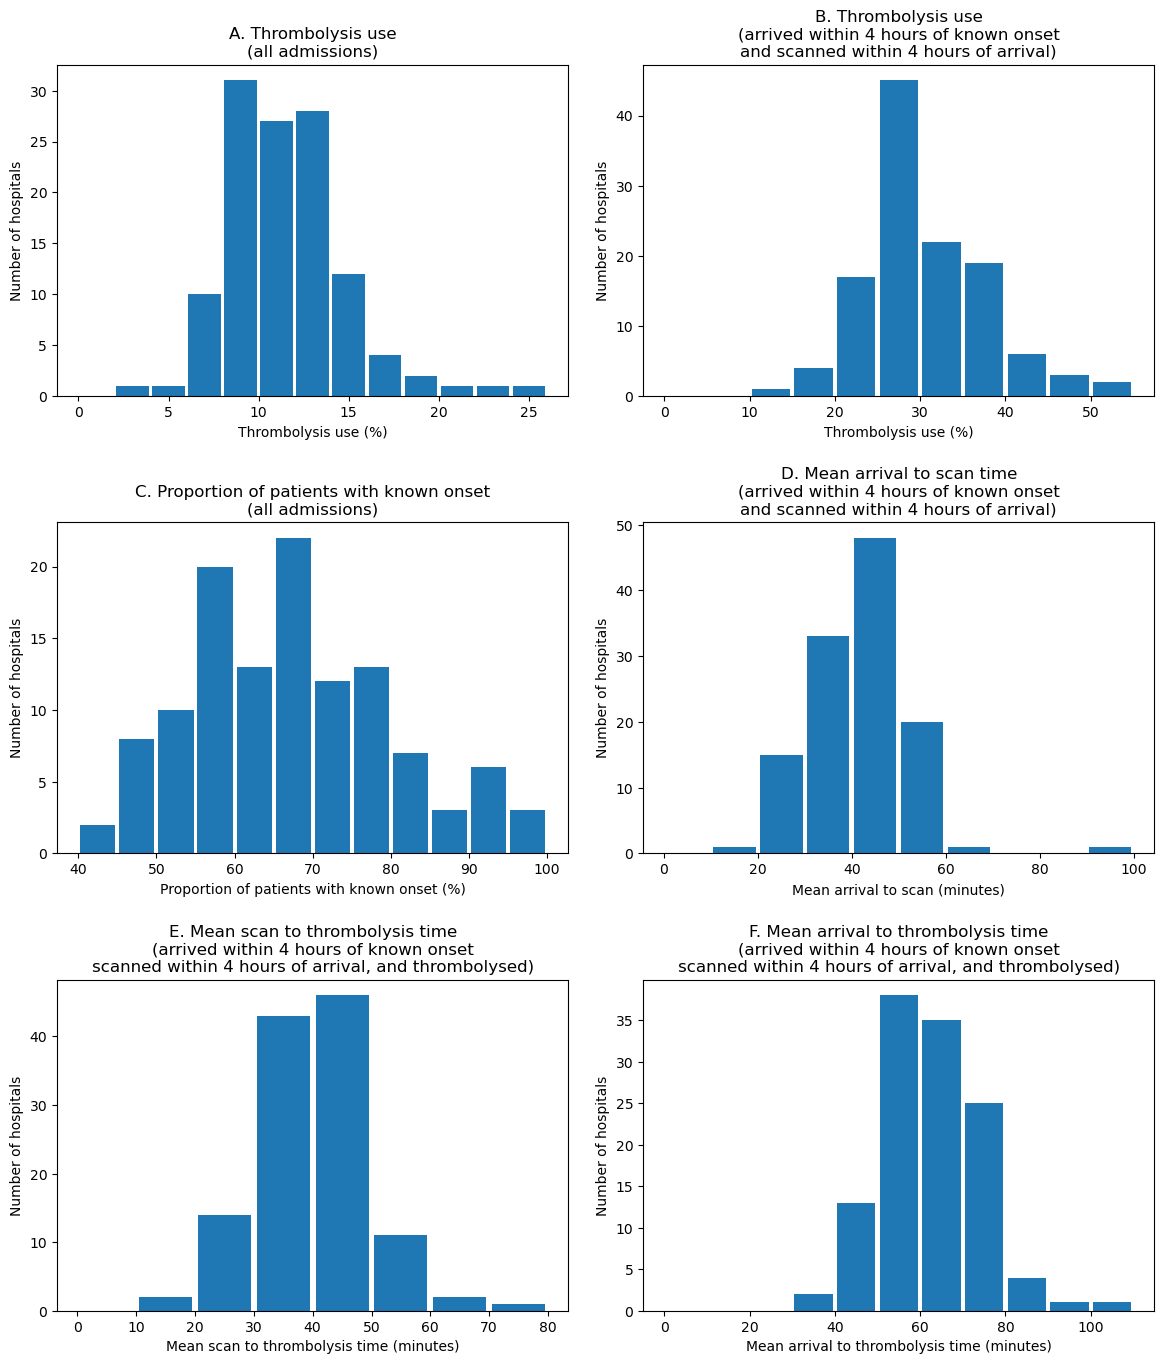

In [10]:
# Set up figure
fig, ax = plt.subplots(3, 2, figsize=(12, 14))

# Plot of thrombolysis rate
x = res_team['prop_thrombolysis_all'] * 100
bins = np.arange(start=0, stop=x.max()+2, step=2)
ax[0, 0].hist(x, bins=bins, rwidth=0.9)
ax[0, 0].set_xlabel('Thrombolysis use (%)')
ax[0, 0].set_ylabel('Number of hospitals')
ax[0, 0].set_title('A. Thrombolysis use\n(all admissions)')

# Plot of thrombolysis rate (4hr known onset, 4hr scan)
x = res_team['prop_thrombolysis_4h_known_4h_scan'] * 100
bins = np.arange(start=0, stop=x.max()+5, step=5)
ax[0, 1].hist(x, bins=bins, rwidth=0.9)
ax[0, 1].set_xlabel('Thrombolysis use (%)')
ax[0, 1].set_ylabel('Number of hospitals')
ax[0, 1].set_title('''B. Thrombolysis use
(arrived within 4 hours of known onset
and scanned within 4 hours of arrival)''')

# Plot of proportion of patients with known onset
x = res_team['prop_onset_known_all'] * 100
bins = np.arange(start=40, stop=x.max()+5, step=5)
ax[1, 0].hist(x, bins=bins, rwidth=0.9)
ax[1, 0].set_xlabel('Proportion of patients with known onset (%)')
ax[1, 0].set_ylabel('Number of hospitals')
ax[1, 0].set_title('''C. Proportion of patients with known onset
(all admissions)''')

# Plot of mean arrival to scan time (4hr known onset, 4hr scan)
x = res_team['mean_arrival_to_scan_4h_known_4h_scan']
bins = np.arange(0, x.max()+10, 10)
ax[1, 1].hist(x, bins=bins, rwidth=0.9)
ax[1, 1].set_xlabel('Mean arrival to scan (minutes)')
ax[1, 1].set_ylabel('Number of hospitals')
ax[1, 1].set_title('''D. Mean arrival to scan time
(arrived within 4 hours of known onset
and scanned within 4 hours of arrival)''')

# Plot of mean scan to needle time
x = res_team['mean_scan_to_thrombolysis_4h_known_4h_scan_t']
bins = np.arange(0, x.max()+10, 10)
ax[2, 0].hist(x, bins=bins, rwidth=0.9)
ax[2, 0].set_xlabel('Mean scan to thrombolysis time (minutes)')
ax[2, 0].set_ylabel('Number of hospitals')
ax[2, 0].set_title('''E. Mean scan to thrombolysis time
(arrived within 4 hours of known onset
scanned within 4 hours of arrival, and thrombolysed)''')

# Plot of mean arrival to needle time
x = res_team['mean_arrival_to_thrombolysis_4h_known_4h_scan_t']
bins = np.arange(0, x.max()+10, 10)
ax[2, 1].hist(x, bins=bins, rwidth=0.9)
ax[2, 1].set_xlabel('Mean arrival to thrombolysis time (minutes)')
ax[2, 1].set_ylabel('Number of hospitals')
ax[2, 1].set_title('''F. Mean arrival to thrombolysis time
(arrived within 4 hours of known onset
scanned within 4 hours of arrival, and thrombolysed)''')

# Show figure
plt.tight_layout(pad=2)
plt.show()

## Stroke severity

In [11]:
def plot_stroke_severity(df, title):
    '''
    Plot stroke severity
    '''
    # Find count and cumulative count of people with each NIHSS score
    # on arrival and those counts as a proportion of all patients
    nihss_arrival = (
        df['stroke_severity']
        .value_counts(dropna=True)
        .sort_index()
        .reset_index()
        .rename(columns={'stroke_severity': 'sum',
                         'index': 'nihss_arrival'}))
    nihss_arrival['cum_sum'] = np.cumsum(nihss_arrival['sum'])
    nihss_arrival['sum_prop'] = (nihss_arrival['sum'] /
                                 nihss_arrival['sum'].sum())
    nihss_arrival['cum_sum_prop'] = (
        nihss_arrival['cum_sum'] / nihss_arrival['sum'].sum())

    # Plot those NIHSS score proportions
    fig, ax1 = plt.subplots(figsize=(7, 5))

    # Proportion
    ax1.plot(nihss_arrival['nihss_arrival'],
             nihss_arrival['sum_prop'], color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylim(0, 0.14)
    ax1.set_ylabel('Proportion of all patients', color='b')
    ax1.grid(axis='x')

    # Cumulative proportion
    ax2 = ax1.twinx()
    ax2.plot(nihss_arrival['nihss_arrival'],
             nihss_arrival['cum_sum_prop'], color='r')
    ax2.set_ylim(0, 1.02)
    ax2.set_yticks(np.arange(0, 1.01, 0.1))
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylabel('Cumulative proportion of all patients', color='r')
    ax2.grid(axis='y')

    # Shared features
    ax1.set_xlabel('NIHSS')
    ax1.set_xlim(0, 45)
    ax1.set_xticks(np.arange(0, 45, 5))
    plt.title(title)
    plt.show()

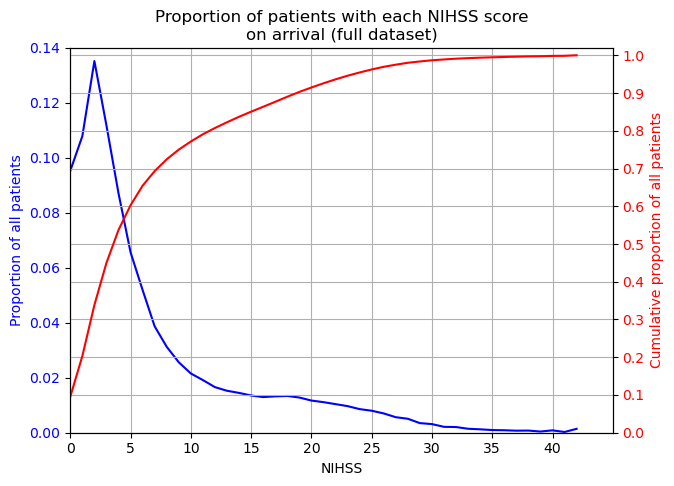

In [12]:
plot_stroke_severity(data_full, '''Proportion of patients with each NIHSS score
on arrival (full dataset)''')

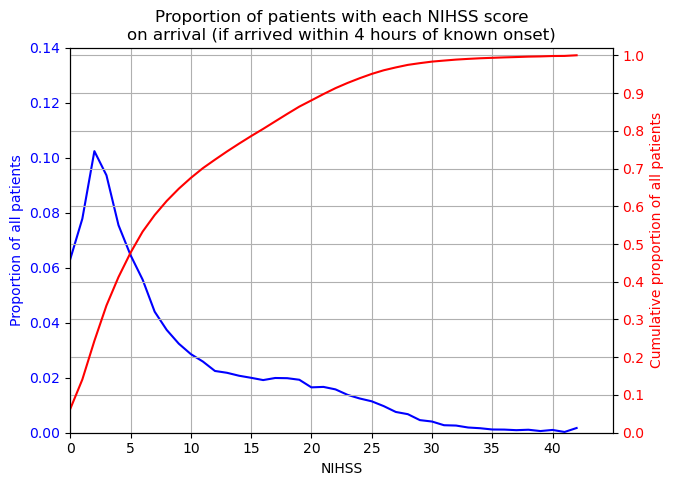

In [13]:
plot_stroke_severity(data, '''Proportion of patients with each NIHSS score
on arrival (if arrived within 4 hours of known onset)''')

## Onset to arrival times

In [14]:
def count_onset_to_arrival(df, heading):
    '''
    Find the frequency of onset to arrival times for each
    half hour window (up to 12 hours)
    '''
    # Proportion of patients with an NIHSS score on arrival
    prop_determined_nihss = (df['stroke_severity'] >= 0).mean()

    # Proportion of patients with known onset
    known_onset_mask = df['onset_known'] == 1
    prop_known_onset = known_onset_mask.mean()

    # Restrict to known onset and get counts of arrival times, up to 12 hours
    df_known = df[known_onset_mask]
    bins = np.arange(start=0, stop=12.01, step=0.5)
    arrival_hours, _ = np.histogram(df_known['onset_to_arrival_time']/60, bins)
    arrival_counts = pd.DataFrame({
        'arrive_bin_upper': bins[1:],
        'sum': arrival_hours,
        'prop': arrival_hours / known_onset_mask.sum()})
    arrival_counts['cum_prop'] = np.cumsum(arrival_counts['prop'])

    # Find proportion of those with known onset arriving within 12h
    prop_known_arrive_12h = arrival_counts['sum'].sum() / len(df_known.index)

    # Print summary of key facts
    print(heading + f''':
    -------------
    Proportion of arrivals with determined NIHSS: {prop_determined_nihss:0.3f}
    Proportion of arrivals with known stroke onset: {prop_known_onset:0.3f}
    Proportion with known onset arriving within 12h: {
        prop_known_arrive_12h:0.3f}
    ''')

    return (arrival_counts)

In [15]:
def plot_onset_to_arrival(df, filter):
    '''
    Plot of counts and proportions of patients with each
    onset to arrival times. Uses the dataframe output by
    the function count_onset_to_arrival().
    '''
    # Create plot of proportion and cumulative proportion
    fig, ax1 = plt.subplots(figsize=(7, 5))

    # Proportion
    ax1.bar(df['arrive_bin_upper']-0.5,
            df['prop'],
            align='edge', width=0.47)
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylabel('Proportion of all patients', color='b')
    ax1.grid(axis='x')

    # Cumulative proportion
    ax2 = ax1.twinx()
    ax2.plot(df['arrive_bin_upper']-0.25,
             df['cum_prop'], color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(0, 1.02)
    ax2.set_ylabel('Cumulative proportion of all patients', color='r')
    ax2.grid(axis='y')

    # Shared features
    ax1.set_xlabel('Arrival time (hours)')
    ax1.set_xlim(0, 12)

    plt.title('''Proportion of patients with each arrival time
    (''' + filter + ')')
    plt.show()

All arrivals:
    -------------
    Proportion of arrivals with determined NIHSS: 1.000
    Proportion of arrivals with known stroke onset: 0.670
    Proportion with known onset arriving within 12h: 0.788
    


,arrive_bin_upper,sum,prop,cum_prop
0,0.5,2643,0.010990,0.010990
1,1.0,16175,0.067255,0.078245
2,1.5,34572,0.143749,0.221994
3,2.0,29199,0.121409,0.343403
4,2.5,20118,0.083650,0.427053
5,3.0,14330,0.059584,0.486636
6,3.5,10884,0.045255,0.531892
7,4.0,8678,0.036083,0.567974
8,4.5,6987,0.029052,0.597026
9,5.0,5942,0.024707,0.621733


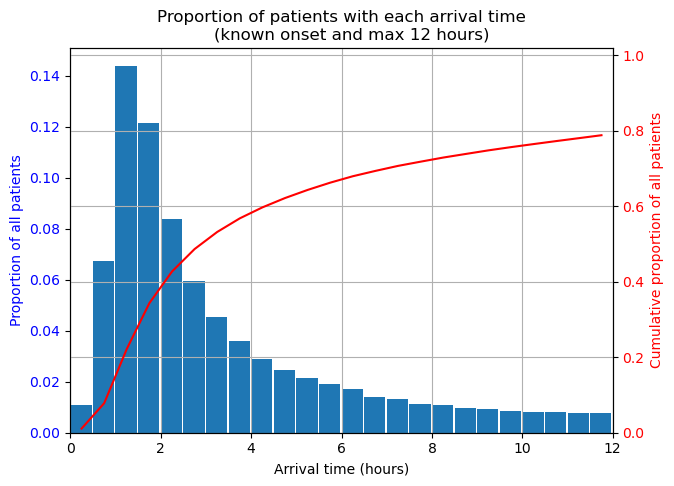

In [16]:
arrival_all = count_onset_to_arrival(data_full, 'All arrivals')
display(arrival_all)
plot_onset_to_arrival(arrival_all, 'known onset and max 12 hours')

In [17]:
# Create same dataframes, but filtered by stroke severity
arrival_under_5 = count_onset_to_arrival(
    data_full[data_full['stroke_severity'] <= 5],
    'Mild stroke (NIHSS <= 5)')

arrival_over_5 = count_onset_to_arrival(
    data_full[data_full['stroke_severity'] > 5],
    'Non-mild stroke (NIHSS > 5)')

arrival_over_10 = count_onset_to_arrival(
    data_full[data_full['stroke_severity'] > 10],
    'Non-mild stroke (NIHSS > 10)')

Mild stroke (NIHSS <= 5):
    -------------
    Proportion of arrivals with determined NIHSS: 1.000
    Proportion of arrivals with known stroke onset: 0.639
    Proportion with known onset arriving within 12h: 0.718
    
Non-mild stroke (NIHSS > 5):
    -------------
    Proportion of arrivals with determined NIHSS: 1.000
    Proportion of arrivals with known stroke onset: 0.718
    Proportion with known onset arriving within 12h: 0.882
    
Non-mild stroke (NIHSS > 10):
    -------------
    Proportion of arrivals with determined NIHSS: 1.000
    Proportion of arrivals with known stroke onset: 0.727
    Proportion with known onset arriving within 12h: 0.909
    


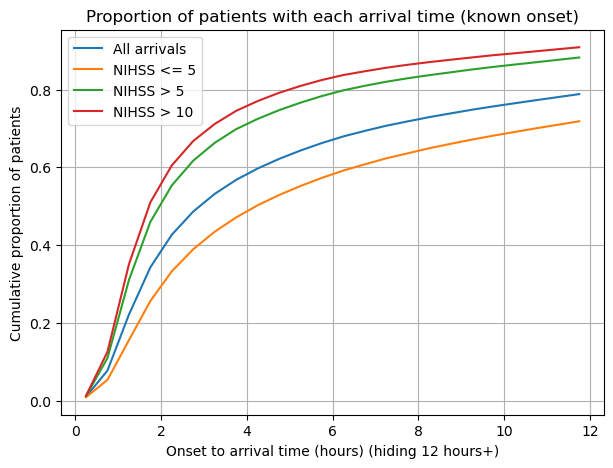

In [18]:
# Compare onset to arrival times depending on stroke severity
fig, ax = plt.subplots(figsize=(7, 5))

# Plot at centre of bin
x = arrival_all['arrive_bin_upper'] - 0.25

ax.plot(x, arrival_all['cum_prop'], label='All arrivals')
ax.plot(x, arrival_under_5['cum_prop'], label='NIHSS <= 5')
ax.plot(x, arrival_over_5['cum_prop'], label='NIHSS > 5')
ax.plot(x, arrival_over_10['cum_prop'], label='NIHSS > 10')

plt.title('Proportion of patients with each arrival time (known onset)')
plt.xlabel('Onset to arrival time (hours) (hiding 12 hours+)')
plt.ylabel('Cumulative proportion of patients')
ax.legend(loc='upper left')
ax.grid()

plt.show()

## Arrival times and stroke severity

In [19]:
time_basic = dict()
time_sev = dict()

# Proportion thrombolysed
thrombolysed_mask = (data_full['thrombolysis'] == 1)
time_basic['Prop thrombolysed (all)'] = thrombolysed_mask.mean()
thrombolysed = data_full[thrombolysed_mask]

# Proportion thrombolysed + known onset
onset_mask = (thrombolysed['onset_known'] == 1)
time_basic['Prop onset known (thrombolysed)'] = onset_mask.mean()
onset_known = thrombolysed[onset_mask]

# For all of those patients, times within 4 and 6 hours
time_sev['Prop arrive within 4 hours'] = (
    onset_known['onset_to_arrival_time'] <= 240).mean()
time_sev['Prop arrive within 6 hours'] = (
    onset_known['onset_to_arrival_time'] <= 360).mean()

# For severity of 5 or less, times within 4 and 6 hours
time_mild_mask = (onset_known['stroke_severity'] <= 5)
time_sev['Prop NIHSS <= 5'] = time_mild_mask.mean()
time_5 = onset_known[time_mild_mask]
time_sev['Prop arrive within 4 hours (NIHSS <= 5)'] = (
    time_5['onset_to_arrival_time'] <= 240).mean()
time_sev['Prop arrive within 6 hours (NIHSS <= 5)'] = (
    time_5['onset_to_arrival_time'] <= 360).mean()

# For severity over 5, times within 4 and 6 hours
time_5_mask = (onset_known['stroke_severity'] > 5)
time_sev['Prop NIHSS > 5'] = time_5_mask.mean()
time_5 = onset_known[time_5_mask]
time_sev['Prop arrive within 4 hours (NIHSS > 5)'] = (
    time_5['onset_to_arrival_time'] <= 240).mean()
time_sev['Prop arrive within 6 hours (NIHSS > 5)'] = (
    time_5['onset_to_arrival_time'] <= 360).mean()

# For severity over 10, times within 4 and 6 hours
time_10_mask = (onset_known['stroke_severity'] > 10)
time_sev['Prop NIHSS > 10'] = time_10_mask.mean()
time_10 = onset_known[time_10_mask]
time_sev['Prop arrive within 4 hours (NIHSS > 10)'] = (
    time_10['onset_to_arrival_time'] <= 240).mean()
time_sev['Prop arrive within 6 hours (NIHSS > 10)'] = (
    time_10['onset_to_arrival_time'] <= 360).mean()

display(pd.Series(time_basic))
print('Analysis of patients who had known onset and were thrombolysed...')
print('Further filters indicated by brackets (i.e. filter by severity)')
display(pd.Series(time_sev))

Prop thrombolysed (all)            0.114636
Prop onset known (thrombolysed)    0.985902
dtype: float64

Analysis of patients who had known onset and were thrombolysed...
Further filters indicated by brackets (i.e. filter by severity)


Prop arrive within 4 hours                 0.987525
Prop arrive within 6 hours                 0.997239
Prop NIHSS <= 5                            0.269569
Prop arrive within 4 hours (NIHSS <= 5)    0.985275
Prop arrive within 6 hours (NIHSS <= 5)    0.996890
Prop NIHSS > 5                             0.730431
Prop arrive within 4 hours (NIHSS > 5)     0.988355
Prop arrive within 6 hours (NIHSS > 5)     0.997367
Prop NIHSS > 10                            0.429920
Prop arrive within 4 hours (NIHSS > 10)    0.987957
Prop arrive within 6 hours (NIHSS > 10)    0.997247
dtype: float64

*Note: Proportion look very different to SAMuEL-1 here, as SAMueL-1 calculated the proportion with NIHSS score <=5 arriving within 4 hours, out of all patients in the dataset, whereas above, it is the proportion arriving within 4 hours, out of all patients with an NIHSS score <=5 and known onset*

## Observations

In [20]:
# Convert res all to series
res_all_s = res_all.squeeze()

# Create empty dictionary to store results for printing
p = dict()

# Looking at all hospitals...
p['n_arr'] = res_all_s['n_arrivals_all']
p['n_team'] = len(res_team.index)
p['ivt'] = res_all_s['prop_thrombolysis_all']*100
p['know'] = res_all_s['prop_onset_known_all']*100
p['know4'] = res_all_s['prop_known_onset_to_arrival_4h_or_less_all']*100
p['time'] = res_all_s['mean_onset_to_arrival_4h_known']
p['scan'] = res_all_s['prop_arrival_to_scan_4h_or_less_4h_known']*100
p['4scan'] = res_all_s['mean_arrival_to_scan_4h_known_4h_scan']
p['4ivt'] = res_all_s['prop_thrombolysis_4h_known_4h_scan']*100
p['4tscan'] = res_all_s['mean_scan_to_thrombolysis_4h_known_4h_scan_t']
p['4tarr'] = res_all_s['mean_arrival_to_thrombolysis_4h_known_4h_scan_t']
p['4tonset'] = res_all_s['mean_onset_to_thrombolysis_4h_known_4h_scan_t']

print(f'''Looking at all hospitals...

There are {p['n_arr']} admissions from {p['n_team']} stroke teams.
This includes 2016-2021, but for each team, only years with 20+ admissions.
They are all out-of-hospital onset.
- {p['ivt']:.1f}% receive thrombolysis
- {p['know']:.1f}% have a known stroke onset
- {p['know4']:.1f}% have a known stroke onset and arrive within 4 hours

Of those arriving within 4 hours of known stroke onset:
- Mean onset to arrival time is {p['time']:.1f} minutes
- {p['scan']:.1f}% receive a scan within 4 hours of arrival

Of those arriving within 4 hours of known stroke onset and
receiving a scan within 4 hours of arrival:
- Mean arrival to scan time is {p['4scan']:.1f} minutes
- {p['4ivt']:.1f}% receive thrombolysis
- Mean scan to thrombolysis time is {p['4tscan']:.1f} minutes
- Mean arrival to thrombolysis time is {p['4tarr']:.1f} minutes
- Mean onset to thrombolysis time is {p['4tonset']:.1f} mintues
''')

Looking at all hospitals...

There are 358884 admissions from 119 stroke teams.
This includes 2016-2021, but for each team, only years with 20+ admissions.
They are all out-of-hospital onset.
- 11.5% receive thrombolysis
- 67.0% have a known stroke onset
- 57.0% have a known stroke onset and arrive within 4 hours

Of those arriving within 4 hours of known stroke onset:
- Mean onset to arrival time is 113.8 minutes
- 95.3% receive a scan within 4 hours of arrival

Of those arriving within 4 hours of known stroke onset and
receiving a scan within 4 hours of arrival:
- Mean arrival to scan time is 41.5 minutes
- 30.7% receive thrombolysis
- Mean scan to thrombolysis time is 37.1 minutes
- Mean arrival to thrombolysis time is 60.1 minutes
- Mean onset to thrombolysis time is 159.4 mintues



In [21]:
# Describe res team (team-level results, summarise them for patterns across)
res_team_d = res_team.describe()


def get_from_res_team_d(calculation, column):
    '''
    Extracts value from res_team_d
    calculation - index name (e.g. min, mean)
    column - column name (e.g. prop_thrombolysis_all)
    '''
    result = res_team_d.iloc[res_team_d.index.get_loc(calculation),
                             res_team_d.columns.get_loc(column)]
    return result


# Inter-hospital variation...
p['itmin'] = get_from_res_team_d('min', 'prop_thrombolysis_all')*100
p['itmax'] = get_from_res_team_d('max', 'prop_thrombolysis_all')*100
p['i4tmin'] = get_from_res_team_d(
    'min', 'prop_thrombolysis_4h_known_4h_scan')*100
p['i4tmax'] = get_from_res_team_d(
    'max', 'prop_thrombolysis_4h_known_4h_scan')*100
p['iomin'] = get_from_res_team_d('min', 'prop_onset_known_all')*100
p['iomax'] = get_from_res_team_d('max', 'prop_onset_known_all')*100
p['i4min'] = get_from_res_team_d(
    'min', 'prop_known_onset_to_arrival_4h_or_less_all')*100
p['i4max'] = get_from_res_team_d(
    'max', 'prop_known_onset_to_arrival_4h_or_less_all')*100
p['i4scanmin'] = get_from_res_team_d(
    'min', 'prop_arrival_to_scan_4h_or_less_4h_known')*100
p['i4scanmax'] = get_from_res_team_d(
    'max', 'prop_arrival_to_scan_4h_or_less_4h_known')*100
p['i480min'] = get_from_res_team_d('min', 'prop_80_plus_4h_known')*100
p['i480max'] = get_from_res_team_d('max', 'prop_80_plus_4h_known')*100
p['i4sevmin'] = get_from_res_team_d(
    'min', 'mean_nihss_on_arrival_4h_known')
p['i4sevmax'] = get_from_res_team_d(
    'max', 'mean_nihss_on_arrival_4h_known')
p['i44smin'] = get_from_res_team_d(
    'min', 'mean_arrival_to_scan_4h_known_4h_scan')
p['i44smax'] = get_from_res_team_d(
    'max', 'mean_arrival_to_scan_4h_known_4h_scan')
p['i44tmin'] = get_from_res_team_d(
    'min', 'mean_arrival_to_thrombolysis_4h_known_4h_scan_t')
p['i44tmax'] = get_from_res_team_d(
    'max', 'mean_arrival_to_thrombolysis_4h_known_4h_scan_t')

print(f'''Inter-hospital variation...

Proportion receiving thrombolysis varies from '''
      f'''{p['itmin']:.1f}% to {p['itmax']:.1f}%.
For patients arriving within 4 hours of known stroke onset and
scanned within 4 hours of arrival, this varies from '''
      f'''{p['i4tmin']:.1f}% to {p['i4tmax']:.1f}%.

Proportion with known stroke onset varies from '''
      f'''{p['iomin']:.1f}% to {p['iomax']:.1f}%.

Proportion arriving within 4 hours of known onset varies from '''
      f'''{p['i4min']:.1f}% to {p['i4max']:.1f}%
Of those arriving within 4 hours of known stroke onset:
- Proportion scanned within 4 hours of arrival ranges from '''
      f'''{p['i4scanmin']:.1f}% to {p['i4scanmax']:.1f}%
- Proportion of patients aged 80+ varies from '''
      f'''{p['i480min']:.1f}% to {p['i480max']:.1f}%
- Mean NIHSS (stroke severity) ranges from '''
      f'''{p['i4sevmin']:.1f} to {p['i4sevmax']:.1f}

Of those arriving within 4 hours of known stroke onset and
receiving a scan within 4 hours of arrival:
- Mean arrival to scan time ranges from '''
      f'''{p['i44smin']:.0f} to {p['i44smax']:.0f} minutes
- Mean arrival to thrombolysis ranges from '''
      f'''{p['i44tmin']:.0f} to {p['i44tmax']:.0f} minutes
''')

Inter-hospital variation...

Proportion receiving thrombolysis varies from 2.0% to 25.0%.
For patients arriving within 4 hours of known stroke onset and
scanned within 4 hours of arrival, this varies from 13.2% to 53.2%.

Proportion with known stroke onset varies from 41.4% to 99.2%.

Proportion arriving within 4 hours of known onset varies from 31.2% to 78.4%
Of those arriving within 4 hours of known stroke onset:
- Proportion scanned within 4 hours of arrival ranges from 84.6% to 99.3%
- Proportion of patients aged 80+ varies from 23.5% to 56.2%
- Mean NIHSS (stroke severity) ranges from 6.4 to 11.2

Of those arriving within 4 hours of known stroke onset and
receiving a scan within 4 hours of arrival:
- Mean arrival to scan time ranges from 20 to 90 minutes
- Mean arrival to thrombolysis ranges from 35 to 103 minutes



In [22]:
# Convert to series
res_u80s = res_all_under_80.squeeze()
res_o80s = res_all_80_plus.squeeze()

# Extract relevant results
p['u80ivt'] = res_u80s['prop_thrombolysis_all']*100
p['o80ivt'] = res_o80s['prop_thrombolysis_all']*100
p['u80arr4'] = res_u80s['prop_known_onset_to_arrival_4h_or_less_all']*100
p['o80arr4'] = res_o80s['prop_known_onset_to_arrival_4h_or_less_all']*100
p['u80mrs'] = res_u80s['mean_rankin_before_stroke_all']
p['o80mrs'] = res_o80s['mean_rankin_before_stroke_all']
p['u80sev'] = res_u80s['mean_nihss_on_arrival_all']
p['o80sev'] = res_o80s['mean_nihss_on_arrival_all']
p['u804t'] = res_u80s['prop_thrombolysis_4h_known_4h_scan']*100
p['o804t'] = res_o80s['prop_thrombolysis_4h_known_4h_scan']*100

# Print description of results
print(f'''Differences between age groups (under 80 v.s. 80+)...

Thrombolysis rate: {p['u80ivt']:.1f}% v.s. {p['o80ivt']:.1f}%

Arrive within 4 hours of known stroke onset: '''
      f'''{p['u80arr4']:.1f}% v.s. {p['o80arr4']:.1f}%

Mean disability (Rankin) before stroke: '''
      f'''{p['u80mrs']:.1f} v.s. {p['o80mrs']:.1f}

Mean stroke severity (NIHSS) on arrival: '''
      f'''{p['u80sev']:.1f} v.s. {p['o80sev']:.1f}

Of those arriving within 4 hours of known stroke onset and
receiving a scan within 4 hours of arrival:
- Thrombolysis rate: {p['u804t']:.1f}% v.s. {p['o804t']:.1f}%
''')

Differences between age groups (under 80 v.s. 80+)...

Thrombolysis rate: 12.7% v.s. 9.6%

Arrive within 4 hours of known stroke onset: 55.2% v.s. 59.9%

Mean disability (Rankin) before stroke: 0.6 v.s. 1.6

Mean stroke severity (NIHSS) on arrival: 5.9 v.s. 8.8

Of those arriving within 4 hours of known stroke onset and
receiving a scan within 4 hours of arrival:
- Thrombolysis rate: 34.4% v.s. 25.3%



In [23]:
p['mildknow'] = (data_full.loc[data_full['stroke_severity'] <= 5,
                               'onset_known'] == 1).mean()*100
p['nonknow'] = (data_full.loc[data_full['stroke_severity'] > 5,
                              'onset_known'] == 1).mean()*100
p['mildarr4'] = time_sev['Prop arrive within 4 hours (NIHSS <= 5)']*100
p['mildarr6'] = time_sev['Prop arrive within 6 hours (NIHSS <= 5)']*100
p['nonarr4'] = time_sev['Prop arrive within 4 hours (NIHSS > 5)']*100
p['nonarr6'] = time_sev['Prop arrive within 6 hours (NIHSS > 5)']*100

print(f'''Onset to arrival times...

Proportion of patients with known stroke onset:
- Non-mild stroke (NIHSS > 5): {p['mildknow']:.1f}%
- Mild stroke (NIHSS <= 5): {p['nonknow']:.1f}%

Of patients with known stroke onset, proportion arriving within 4 and 6 hours:
- Non-mild stroke (NIHSS > 5): {p['nonarr4']:.1f}% and {p['nonarr6']:.1f}%
- Mild stroke (NIHSS <= 5): {p['mildarr4']:.1f}% and {p['mildarr6']:.1f}%
''')

Onset to arrival times...

Proportion of patients with known stroke onset:
- Non-mild stroke (NIHSS > 5): 63.9%
- Mild stroke (NIHSS <= 5): 71.8%

Of patients with known stroke onset, proportion arriving within 4 and 6 hours:
- Non-mild stroke (NIHSS > 5): 98.8% and 99.7%
- Mild stroke (NIHSS <= 5): 98.5% and 99.7%

